In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5324.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3382.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1398.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1142.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5002.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2646.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3476.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1613.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5593.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2975.BMP
/kaggle/input/finger-print-based-blood-g

In [7]:
import os, glob
import numpy as npi
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split #splits data for training and testing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report

In [9]:
filepath = "/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group"
blood_groups = os.listdir(filepath)
print(blood_groups)

['AB-', 'O+', 'B-', 'B+', 'A-', 'A+', 'O-', 'AB+']


In [15]:
all_file_paths = []
y = []
count=0

for root,dirs,files in os.walk(filepath):
    if(len(files)!=0):
        for file in files:
            all_file_paths.append(os.path.join(root,file))
            y.append(blood_groups[count])
        count = count+1

In [16]:
data = pd.DataFrame()
data['files'] = all_file_paths
data['blood_group'] = y
data.head()

,files,blood_group
0,/kaggle/input/finger-print-based-blood-group-d...,AB-
1,/kaggle/input/finger-print-based-blood-group-d...,AB-
2,/kaggle/input/finger-print-based-blood-group-d...,AB-
3,/kaggle/input/finger-print-based-blood-group-d...,AB-
4,/kaggle/input/finger-print-based-blood-group-d...,AB-


In [26]:
data.shape

(6000, 2)

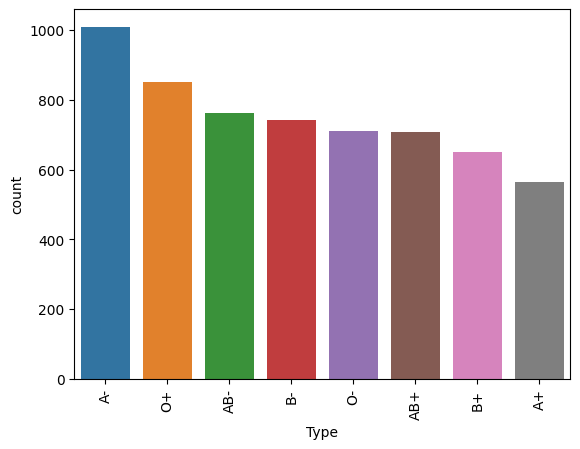

In [20]:
counts = data.blood_group.value_counts()
sns.barplot(x = counts.index,y=counts)
plt.xlabel("Type")
plt.xticks(rotation=90)
plt.show()

In [21]:
train_df,test_df = train_test_split(data,test_size=0.25,random_state=42)

## converting images to data

In [22]:
## creating an instance of datagenerator
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [25]:
## using the data generator
train_generation = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'files',
    y_col = 'blood_group',
    target_size = (256,256),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42
)

val_generation = train_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'files',
    y_col = 'blood_group',
    target_size = (256,256),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42
)

test_generation = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'files',
    y_col = 'blood_group',
    target_size = (256,256),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42
)

Found 4500 validated image filenames belonging to 8 classes.
Found 1500 validated image filenames belonging to 8 classes.
Found 1500 validated image filenames belonging to 8 classes.


## using a pretrained resnet

In [28]:
resnet_model = ResNet50(
    input_shape=(256,256,3),
    include_top=False,
    weights = 'imagenet',
    pooling= 'avg',
)
resnet_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [32]:
resnet_input= resnet_model.input
dense_input = resnet_model.output
x = Dense(128, activation='relu')(dense_input)
x = Dense(128, activation = 'relu')(x)

output = Dense(8,activation='softmax')(x)

model = Model(inputs = resnet_input, outputs=output)

In [33]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(train_generation,validation_data=val_generation,epochs=20)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 717s 5s/step - accuracy: 0.4046 - loss: 1.5828 - val_accuracy: 0.6327 - val_loss: 0.9461
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 695s 5s/step - accuracy: 0.6696 - loss: 0.8650 - val_accuracy: 0.6573 - val_loss: 0.8443
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 695s 5s/step - accuracy: 0.7397 - loss: 0.6889 - val_accuracy: 0.6593 - val_loss: 0.8332
Epoch 4/20
 59/141 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - accuracy: 0.7598 - loss: 0.5770